In [1]:
import pandas as pd
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from skimage import measure
%matplotlib inline


In [2]:
img_selecionada = 'BloodImage_00023.jpg'
arquivo = '../dataset/BCCD/JPEGImages/' + img_selecionada

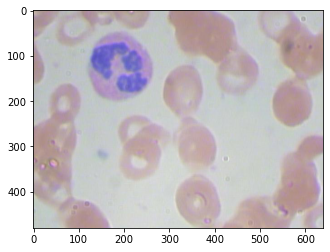

In [3]:
img_original = cv2.imread(arquivo)
#converte para o esquema de cores RGB
img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
#mostra imagem original
plt.imshow(img_rgb)

In [4]:
img_hsv = cv2.cvtColor(img_original,cv2.COLOR_BGR2HSV)

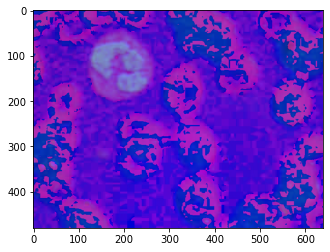

In [5]:
plt.imshow(img_hsv)

In [6]:
img_hsv.shape

(480, 640, 3)

In [7]:
gray = cv2.cvtColor(img_original,cv2.COLOR_BGR2GRAY)

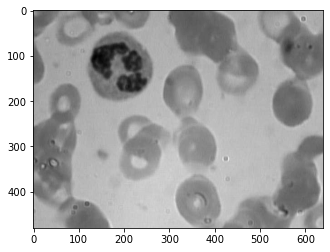

In [8]:
plt.imshow(gray,cmap='gray');

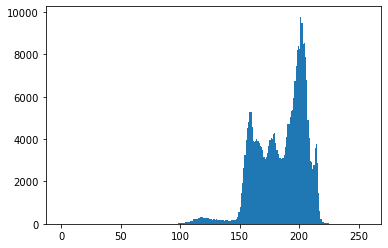

In [9]:
intensidades = gray.ravel()
plt.hist(intensidades,256,[0,256])
plt.show()

In [10]:
b, g, r = cv2.split(img_original)
b_blur = cv2.GaussianBlur(b,(3,3),cv2.BORDER_DEFAULT)

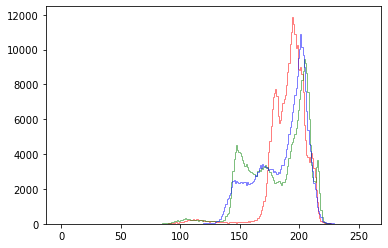

In [11]:
r_intensidades = r.ravel()
g_intensidades = g.ravel()
b_intensidades = b_blur.ravel()

plt.hist(r_intensidades,256,[0,256],alpha=0.5,color='red',histtype='step')
plt.hist(g_intensidades,256,[0,256],alpha=0.5,color='green',histtype='step')
plt.hist(b_intensidades,256,[0,256],alpha=0.5,color='blue',histtype='step')

plt.show()

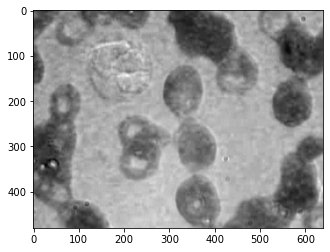

In [12]:
#experiência usando o gaussian blur sobre o canal azul (blue)
plt.imshow(b_blur,cmap='gray');

Text(0.5, 1.0, 'Com median blur')

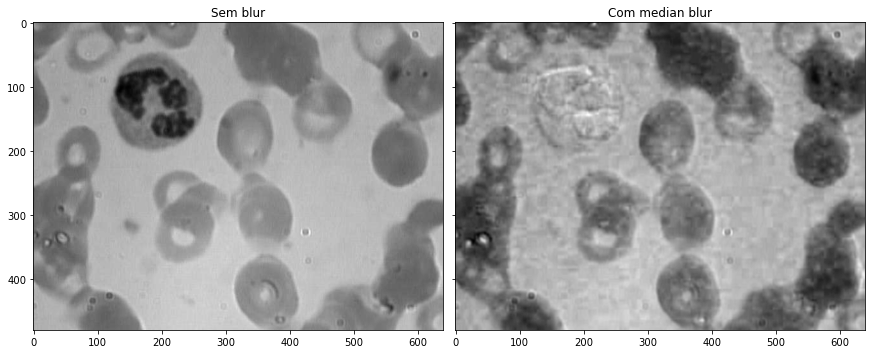

In [13]:
fig2, ax2 = plt.subplots(1,2,constrained_layout=True, sharey=True,figsize=(12,16))
ax2[0].imshow(gray, cmap='gray')
ax2[0].set_title('Sem blur')
ax2[1].imshow(b_blur,cmap='gray')
ax2[1].set_title('Com median blur')

# Experimentação utilizando non local means denoising

[[175. 176. 175. ... 196. 194. 191.]
 [177. 178. 177. ... 198. 196. 194.]
 [180. 180. 180. ... 200. 198. 196.]
 ...
 [198. 197. 197. ... 205. 206. 207.]
 [198. 197. 197. ... 206. 207. 208.]
 [198. 197. 197. ... 206. 207. 208.]]


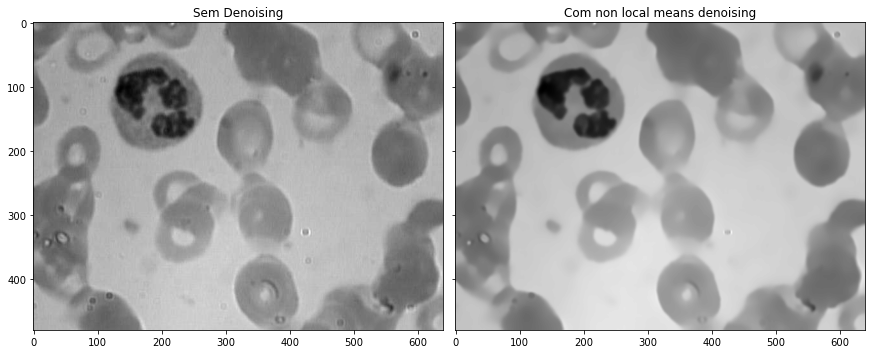

In [14]:
gray_flt = np.float64(gray)
dst = cv2.fastNlMeansDenoising(gray,None,10,7,21)
fig3, ax3 = plt.subplots(1,2,constrained_layout=True, sharey=True,figsize=(12,16))
ax3[0].imshow(gray, cmap='gray')
ax3[0].set_title('Sem Denoising')
ax3[1].imshow(dst,cmap='gray')
ax3[1].set_title('Com non local means denoising')
print(gray_flt)

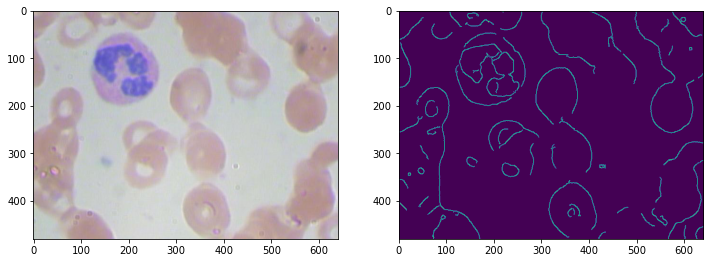

In [15]:
c = cv2.Canny(dst,1, 40)

fig3, ax4 = plt.subplots(1,2,figsize=(12,16))
ax4[0].imshow(img_rgb)
ax4[1].imshow(c)
plt.show()

In [16]:
def show_detected_circles(img_source, circles):
    
    img = np.copy(img_source)
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX

    # fontScale
    fontScale = 1

    # Blue color in BGR
    color = (255, 0, 0)

    # Line thickness of 2 px
    thickness = 2
    if not (circles is None):
        circles = np.uint16(np.around(circles))
        v = 0
        for i in circles[0,:]:
            x = i[0]
            y = i[1]
            raio = i[2]
            # draw the outer circle
            cv2.circle(img,(x,y),raio,(0,255,0),2)

            #print('Circulo: %d , raio: %0.2f Centro:(%d,%d)'% (v,raio,x,y))

            # org
            org = (x-12, y+12)

            #identifica o circulo com o numero do mesmo
            img = cv2.putText(img, str(v), org, font, 
                       fontScale, color, thickness, cv2.LINE_AA)

            # draw the center of the circle
            #cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
            v += 1
    return img

480


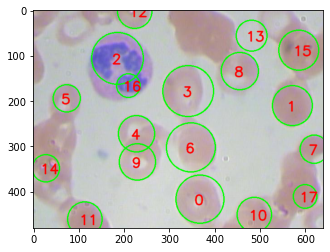

In [36]:
img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
rows = dst.shape[0]
print(rows)
circles = cv2.HoughCircles(dst,cv2.HOUGH_GRADIENT,1, rows/8,
                            param1=20,param2=16,minRadius=24,maxRadius=58)
        # gray: Input image (grayscale).
        # circles: A vector that stores sets of 3 values: xc,yc,r for each detected circle.
        # HOUGH_GRADIENT: Define the detection method. Currently this is the only one available in OpenCV.
        # dp = 1: The inverse ratio of resolution.
        # min_dist = gray.rows/16: Minimum distance between detected centers.
        # param_1 = 200: Upper threshold for the internal Canny edge detector.
        # param_2 = 100*: Threshold for center detection.
        # min_radius = 0: Minimum radius to be detected. If unknown, put zero as default.
        # max_radius = 0: Maximum radius to be detected. If unknown, put zero as default.
    
qtd_circles = len(circles[0])
a = show_detected_circles(img_rgb,circles)

plt.imshow(a)

In [34]:
b = cv2.cvtColor(a,cv2.COLOR_BGR2RGB)
cv2.imwrite('../dataset/images/hough.circles.jpg',b)

True

In [19]:
cv2.__version__

'3.4.2'

In [20]:
df = pd.read_csv('quantidade_celulas_rbc.csv')
df.head()

,filename,total
0,BloodImage_00000.jpg,19
1,BloodImage_00001.jpg,18
2,BloodImage_00002.jpg,15
3,BloodImage_00003.jpg,15
4,BloodImage_00004.jpg,11


In [25]:
#Este laço gera o conjunto total de imagens com os circulos identificados na pasta output
caminho_dataset = '../dataset/BCCD/JPEGImages/'
caminho_output  = '../output/'
for row in df.iterrows():
    arquivo = caminho_dataset + row[1][0]
    #total = row[1][1]
    
    img = cv2.imread(arquivo)
    #blue,green,red = cv2.split(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    gray_blur = cv2.fastNlMeansDenoising(gray,None,10,7,21)
    
    #gray_blur = cv2.GaussianBlur(gray,(3,3),cv2.BORDER_DEFAULT)
    rows = gray_blur.shape[0]
    circles = cv2.HoughCircles(gray_blur,cv2.HOUGH_GRADIENT,1, rows/8,
                            param1=20,param2=22,minRadius=24,maxRadius=65)
    qtd_circles = len(circles[0])
    
    img2 = show_detected_circles(img, circles)
    
    #salva em arquivo
    arquivo_w = caminho_output + row[1][0]
    cv2.imwrite(arquivo_w, img2)
    
    #adicionar dados a lista para o dataframe
    #resultado.append([arquivo,total,qtd_circles,qtd_circles/total])


Docstring:<br>
HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles<br>
.   @brief Finds circles in a grayscale image using the Hough transform.<br>
.   <br>
.   The function finds circles in a grayscale image using a modification of the Hough transform.<br>
.   <br>
.   Example: :<br>
.   @include snippets/imgproc_HoughLinesCircles.cpp<br>
.   <br>
.   @note Usually the function detects the centers of circles well. However, it may fail to find correct<br>
.   radii. You can assist to the function by specifying the radius range ( minRadius and maxRadius ) if<br>
.   you know it. Or, you may set maxRadius to a negative number to return centers only without radius<br>
.   search, and find the correct radius using an additional procedure.<br>
.   <br>
.   @param image 8-bit, single-channel, grayscale input image.<br>
.   @param circles Output vector of found circles. Each vector is encoded as  3 or 4 element<br>
.   floating-point vector \f$(x, y, radius)\f$ or \f$(x, y, radius, votes)\f$ .<br>
.   @param method Detection method, see #HoughModes. Currently, the only implemented method is #HOUGH_GRADIENT<br>
.   @param dp Inverse ratio of the accumulator resolution to the image resolution. For example, if<br>
.   dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has<br>
.   half as big width and height.<br>
.   @param minDist Minimum distance between the centers of the detected circles. If the parameter is<br>
.   too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is<br>
.   too large, some circles may be missed.<br>
.   @param param1 First method-specific parameter. In case of #HOUGH_GRADIENT , it is the higher<br>
.   threshold of the two passed to the Canny edge detector (the lower one is twice smaller).<br>
.   @param param2 Second method-specific parameter. In case of #HOUGH_GRADIENT , it is the<br>
.   accumulator threshold for the circle centers at the detection stage. The smaller it is, the more<br>
.   false circles may be detected. Circles, corresponding to the larger accumulator values, will be<br>
.   returned first.<br>
.   @param minRadius Minimum circle radius.<br>
.   @param maxRadius Maximum circle radius. If <= 0, uses the maximum image dimension. If < 0, returns<br>
.   centers without finding the radius.<br>
.   <br>
.   @sa fitEllipse, minEnclosingCircle<br>
Type:      builtin_function_or_method

In [22]:
def create_circles_mask(img_source, circles):
    
    img = np.zeros((img_source.shape[0],img_source.shape[1]))
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    print(img.shape)

    # fontScale
    fontScale = 1

    # Blue color in BGR
    color = (255, 0, 0)

    # Line thickness of 2 px
    thickness = 2
    if not (circles is None):
        circles = np.uint16(np.around(circles))
        v = 0
        for i in circles[0,:]:
            x = i[0]
            y = i[1]
            raio = i[2]
            # draw the outer circle
            cv2.circle(img,(x,y),raio,(255,255,255),-1)

            #print('Circulo: %d , raio: %0.2f Centro:(%d,%d)'% (v,raio,x,y))

            # org
            org = (x-12, y+12)

            #identifica o circulo com o numero do mesmo
            img = cv2.putText(img, str(v), org, font, 
                       fontScale, color, thickness, cv2.LINE_AA)

            # draw the center of the circle
            #cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
            v += 1
    return img

In [23]:
img_mask_circles = create_circles_mask(img_rgb,circles)

(480, 640)


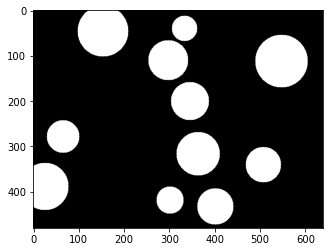

In [24]:
plt.imshow(img_mask_circles,cmap='gray')

# Trechos copiados do notebook cell-recognition-explorer, para fins de reorganização da sequência de operações


In [ ]:
#operações morfológicas
mask = cv2.inRange(img_gray, 30,180)
plt.imshow(mask,cmap='gray')

_, thresh = cv2.threshold(img_gray, 180, 210, cv2.THRESH_BINARY_INV)
plt.imshow(thresh,cmap='gray')

kern = np.ones((4,4), np.uint8)
img_dilate = cv2.dilate(thresh, kern,iterations=3)
plt.imshow(img_dilate,cmap='gray')

eros = cv2.erode(thresh,kern,iterations=2)
plt.imshow(eros,cmap='gray')